In [1]:
import pandas as pd
import numpy as np
import os
import traceback
import pdb
np.seterr(all="ignore")
#--- user libs
import utility as utl
import imp
imp.reload(utl)

<module 'utility' from '/home/karimik/Project/git/DislocationAvalanches/tensile/python/utility.py'>

# set parameters
## load curves

In [3]:
path = '/home/karimik/Project/git/DislocationAvalanches/tensile/testdata/aedata/cantor/Fig1'

#
inputFiles = os.listdir('%s'%(path))
print('inputFiles=',np.array(inputFiles))




inputFiles= ['tensile300k1.txt' 'tensile600k1.txt' 'tensile800k1.txt'
 'tensile900k1.txt' 'tensile700k1.txt']


In [517]:
# def GetIndentLabel(strr):
#     indxi=strr.find('1.txt')
#     print
#     indxf=indxi+2 #strr.find('5000')
#     return strr[indxi:indxf]

# indentLabels = list(map(lambda x:GetIndentLabel(x),inputFiles))
# print(indentLabels)

['13', '7 ', '2 ', '14', '10', '11', '5 ', '4 ', '15', '9 ', '3 ', '8 ', '6 ', '1 ', '12']


In [6]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers:

read_csv(filepath_or_buffer: Union[str, pathlib.Path, IO[~AnyStr]], sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, cache_dates=True, iterator=False, chunksize=None, compression='infer', thousands=None, decimal: str = '.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)
    Read a comma-separated values (csv) file in

# Parse load curves

In [25]:
pd.read_csv('%s/%s'%(path,inputFiles[0]),
            header=None,
            delimiter=' ',
#          sep=' ',
#            index_col=False,names=['Time','Stress'],
           )
#--- read input file
#loadTimeSeries = list(map(lambda x:pd.read_csv('%s/%s'%(path,x),
#                 sep='\t',index_col=False,names=['Time','Depth','Force']),[inputFiles[0]]))
#--- derivative
#loadTimeSeries = list(map(lambda x:pd.DataFrame(np.c_[x,np.gradient(x.Depth,x.Time)],columns=['Time','Depth','Force','Rate']),loadTimeSeries))
#loadTimeSeries[1] #--- index indicates the indenter location

,0,1,2,3
0,5.45000,NaN,9.382856,NaN
1,5.45001,NaN,9.381836,NaN
2,5.45002,NaN,9.380763,NaN
3,5.45003,NaN,9.379645,NaN
4,5.45004,NaN,9.378514,NaN
...,...,...,...,...
24995,5.69995,NaN,9.710364,NaN
24996,5.69996,NaN,9.711204,NaN
24997,5.69997,NaN,9.712087,NaN
24998,5.69998,NaN,9.712953,NaN


# Plot timeseries

indent label:13, grain id:968


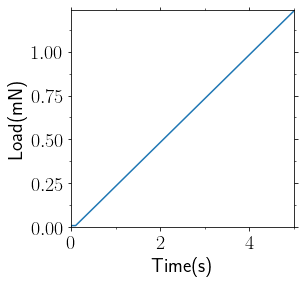

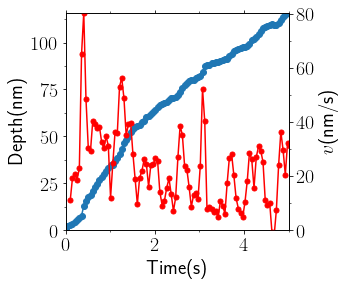

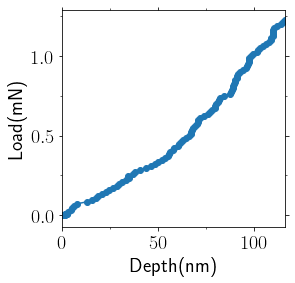

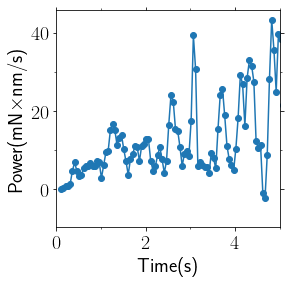

<AxesSubplot:xlabel='Time(s)', ylabel='Power(mN$\\times$nm/s)'>

In [520]:
def GetGrainId(indent,indentLabels,loadID,index):
    indentLabel = indentLabels[index]
    filtr = np.all([indent['label']==int(indentLabel),indent['#loadID']==loadID],axis=0)
    if not np.any(filtr):
        'warning: indenter %s not on the plane!'%indentLabel
        return indentLabel, np.nan
    grainID = indent[filtr]['grainID'].iloc[0]
    return indentLabel, grainID


#--- set limits
index = 0 #--- file index
ld = loadTimeSeries[ index ] #--- file id
indentLabel, grainID = GetGrainId(indent,indentLabels,loadID,index)
print('indent label:%s, grain id:%s'%(indentLabel,grainID))

#--- time
tlo = 0
thi = 5.0 #ld.Time.max()
#--- load
flo = 0
fhi = 1.01*ld['Force'][ld['Time']<thi].max() #ld.Force.max()
#--- depth
hlo = 0.0
hhi = ld['Depth'][ld['Time']<thi].max() #ld.Depth.max()
#--- velocity
vlo = 0.0
vhi = ld.Rate[ld.Rate!=np.inf].max()

#--- load vs. time
utl.PltErr(ld.Time, ld.Force,
           attrs={'fmt':'-'},
           xlim=(tlo,thi),
           ylim=(flo,fhi),
           xstr=r'Time(s)',
           ystr=r'Load(mN)',
           title='png/force_time.png'
          )

#--- depth vs. time
ax = utl.PltErr(ld.Time, ld.Depth,
           xlim=(tlo,thi),
           ylim=(hlo,hhi),
           xstr=r'Time(s)',
           ystr=r'Depth(nm)',
           Plot=False,
          )

#--- velocity vs. time
utl.PltErr(ld.Time, ld.Rate,
           xlim=(tlo,thi),
           ylim=(vlo,vhi),
#           xstr=r'Time',
           ystr=r'$v$(nm/s)',
           attrs={'fmt':'-r.','markersize':10},
           Plot = True,
           twinx = True,
           ax=ax,
#           yscale='log'
           title='png/depth_time.png'
          )


#--- load vs. depth
utl.PltErr(ld.Depth[ld['Time']<thi], ld.Force[ld['Time']<thi],
           xlim=(hlo,hhi),
#            ylim=(0,0.4),
           xstr=r'Depth(nm)',
           ystr=r'Load(mN)',
           title='png/load_depth.png'
          )

#--- power vs. time
utl.PltErr(ld.Time, ld.Force * ld.Rate,
           xlim=(tlo,thi),
#            ylim=(0,1),
           xstr=r'Time(s)',
           ystr=r'Power(mN$\times$nm/s)',
           title='png/power_time.png'
          )

## output timeseries

In [521]:
for index in range(len(loadTimeSeries)): #--- file index
    ld = loadTimeSeries[ index ] #--- file id
    indentLabel, grainID = GetGrainId(indent,indentLabels,loadID,index)
    print('indent label:%s, grain id:%s'%(indentLabel,grainID))
    #
    filtr = np.all([ld.Depth>=hlo,ld.Depth<=hhi,ld.Time<thi],axis=0)
    np.savetxt('grainAttributes/loadDepth/loadDepth_GrainID_%s_LoadID%s_IndentLabel_%s.txt'%(grainID,loadID,int(indentLabel)),
               np.c_[ld.Depth[filtr], ld.Force[filtr]],
               header='Depth(nm)\tForce(mN)',
               fmt='%4.3e\t%4.3e')

indent label:13, grain id:968
indent label:7 , grain id:645
indent label:2 , grain id:nan
indent label:14, grain id:1081
indent label:10, grain id:832
indent label:11, grain id:832
indent label:5 , grain id:463
indent label:4 , grain id:nan
indent label:15, grain id:1081
indent label:9 , grain id:819
indent label:3 , grain id:nan
indent label:8 , grain id:658
indent label:6 , grain id:518
indent label:1 , grain id:nan
indent label:12, grain id:887


# Avalanche statistics

## Power distributions

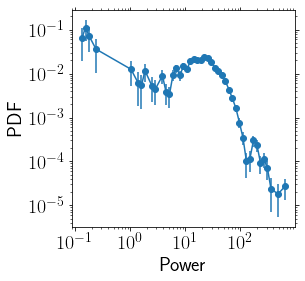

<AxesSubplot:xlabel='Power', ylabel='PDF'>

In [343]:
def GetPower(ld,tlo,thi):
    filtr = np.all([ld.Time>tlo,ld.Time<thi],axis=0)
    value = (ld.Force*ld.Rate)[filtr]
    return (value[ value > 0.0 ]).to_list()

value = np.concatenate(list(map(lambda x:GetPower(x,tlo,thi), loadTimeSeries)))
hist, edge, err = utl.GetPDF(value, n_per_decade=16, linscale=None)

utl.PltErr(edge, hist, yerr=err,
#           xlim=(tlo,thi),
#            ylim=(0,0.4),
           ystr=r'PDF',
           xstr=r'Power',
           xscale = 'log',
           yscale='log',
           title='power_hist.png'
          )

## Avalanche size

In [344]:
def Wrapper_GetAvl(ld,tlo,thi,lambdc):
    '''
    return avalanche sizes given force timeseries and initial and final times
    '''
    
#    print(np.min(GetPower(ld,tlo,thi)))
    
    #--- data frame storing avalanche attributes
    filtr = np.all([ld.Time>tlo,ld.Time<thi],axis=0)

    df_avl = utl.GetAvl( np.array(ld.Time[filtr]), np.array(ld.Force*ld.Rate)[filtr], lambdc)
    #df_avl = GetAvalKunMethod( broken_bonds,  5) #tcrltn )

    #--- save
    # df_fltrd = DataFrameSubSet( df_avl, #--- filter
    #                               'ti', 
    #                               ( 0, tavl ) ) 
    # df_fltrd.to_pickle('df_avl.pk')

#    display( df_avl.sort_values( by = 'size',ascending = False) )
#    print ('n.avls = %s'%len(df_avl))
    return np.array(df_avl['size'].to_list())
    
lambdc = 10.0 #--- threshold
try:
    sizes = np.concatenate(list(map(lambda x:Wrapper_GetAvl(x,tlo,thi,lambdc), loadTimeSeries)))
except:
    print('increase the threshold')

increase the threshold


### accumulated

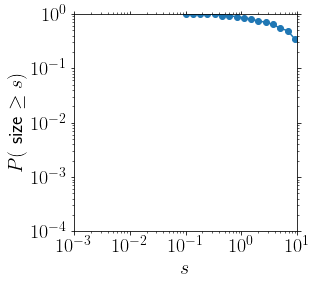

<AxesSubplot:xlabel='$s$', ylabel='$P($ size $\\ge s)$'>

In [345]:
hist, edge = utl.GetPDF(sizes, ACCUM = True, n_per_decade=8, linscale=None)

utl.PltErr(edge[:-1], 1-hist,
           xlim=(1e-3,1e1),
            ylim=(1e-4,1),
           ystr=r'$P($ size $\ge s)$',
           xstr=r'$s$',
           xscale = 'log',
           yscale='log'
          )

### pdf

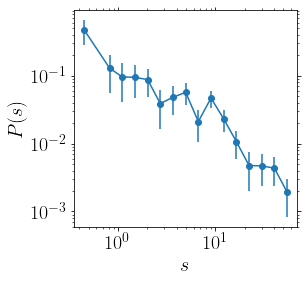

<AxesSubplot:xlabel='$s$', ylabel='$P(s)$'>

In [346]:
hist, edge, err = utl.GetPDF(sizes, n_per_decade=8, linscale=None)

utl.PltErr(edge, hist, yerr=err,
#           xlim=(1e-3,1e1),
#            ylim=(1e-2,1e2),
           ystr=r'$P(s)$',
           xstr=r'$s$',
           xscale = 'log',
           yscale='log'
          )

### vary threshold

In [347]:
def varyThreshold(loadTimeSeries, tlo, thi, lambdc):
    return np.concatenate(list(map(lambda x:Wrapper_GetAvl(x,tlo,thi,lambdc), loadTimeSeries)))

try:
    lambdc = np.logspace(np.log10(1.0e1),np.log10(3.0e1),4)
    size_lambdc = list(map(lambda x:varyThreshold(loadTimeSeries, tlo, thi, x),lambdc))

    #--- distributions
    hists = list(map(lambda x: utl.GetPDF(x, n_per_decade=8, linscale=None), size_lambdc))


    for item, threshold, indx in zip(hists, lambdc, range(len(hists))):
        hist, edge, err = item
        if indx == 0:
            ax = utl.PltErr(edge, hist, yerr=err,
                            Plot = False,
                            legend = True,
                            label=r'$\lambda_c=%3.2f$'%threshold,
                      )
            ax = utl.PltErr(edge, 1/edge**1.3,
                            Plot = False,
                            fmt = '-.r',
                            ax = ax,
                      )
        else:
            ax = utl.PltErr(edge, hist, yerr=err,
    #                        xlim=(1e-3,1e1),
    #                       ylim=(1e-2,1e2),
                           ystr=r'$P(s)$',
                           xstr=r'$s$',
                           xscale = 'log',
                           yscale='log',
                           Plot = False,
                           ax=ax,
                           label=r'$\lambda_c=%3.2f$'%threshold,
                            legend = True,
                            loc=3,
                            fontsize=16,
                           title='avalanche_size.png'
                          )
except:
    print('increase the threshold')

increase the threshold


In [348]:
input_file = '/Users/Home/Desktop/Tmp/txt/git/DislocationAvalanches/nanoindentation/ebsd/attributes.txt'
grain_attr = pd.read_csv(input_file,sep='\t')
grain_attr.head()

,#grainID,x,y,grainSize,perimeter,boundarySize,numNeighbors
0,1,-0.018954,0.068387,1,3.695012,5,1
1,2,-85.909030,-0.799994,1,2.771259,6,1
2,3,-85.909030,-2.399981,1,2.771259,6,2
3,4,-141.335700,-0.852774,10,13.056300,24,3
4,5,-85.909030,-3.199974,1,2.771259,6,3


In [349]:
def Wrapper(index):
    #index = 0 #--- file index
    ld = loadTimeSeries[ index ] #--- file id
    indentLabel = indentLabels[index]

    grainLabel = grainLabels[loadID][indentLabel]
    print('indent label:%s, grain label:%s'%(indentLabel,grainLabel))

    lambdc = 10.0
    avlanche = Wrapper_GetAvl(ld,tlo,thi,lambdc)
    moment_1st = np.mean(avlanche)
    avalanche_sq = avlanche*avlanche
    moment_2nd = np.mean(avalanche_sq)**0.5
    avalanche_4th = avalanche_sq*avalanche_sq
    moment_4th = np.mean(avalanche_4th)**0.25

    grainSize = grain_attr[ grain_attr['#grainID'] == grainLabel ].grainSize
#    pdb.set_trace()
    return grainSize.iloc[0], moment_1st, moment_2nd, moment_4th


#val = np.c_[list(map(lambda x:Wrapper(x),range(len(loadTimeSeries))))]
# utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,1]),
#           attrs={'fmt' : '.',
#           'markersize':10.0},
#             xstr=r'grain size',
#             ystr=r'1st moment',
#            xlim=(-3,3),
#            ylim=(-3,3),
#           )

# utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,2]),
#           attrs={'fmt' : '.',
#           'markersize':10.0},
#             xstr=r'grain size',
#             ystr=r'2nd moment',
#            xlim=(-3,3),
#            ylim=(-3,3),
#           )
# utl.PltErr(val[:,0],val[:,2],
#           attrs={'fmt' : '.',
#           'markersize':10.0},
#             xstr=r'grain size',
#             ystr=r'avalanche size(2nd moment)',
#            title='avalancheSize.png'
# #           xlim=(-3,3),
# #           ylim=(-3,3),
#           )

# utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,3]),
#           attrs={'fmt' : '.',
#           'markersize':10.0},
#             xstr=r'grain size',
#             ystr=r'4th moment',
#            xlim=(-3,3),
#            ylim=(-3,3),
#           )


# Hardness

In [360]:
def func(x,a,b):
    return a * x + b

def MeasureHardness(ld,hlo,hhi,flo,fhi,Plot=False,verbose=False):
    pmax = ld.Force.max()
    tunload = ld.Time[ld.Force>=pmax].iloc[-1]
    dt = 0.4 * tunload
    filtr = np.all([ld.Time>tunload,ld.Time<tunload+dt],axis=0)
    z = np.polyfit(ld.Depth[filtr],ld.Force[filtr],deg=1)
    if Plot:
        utl.PltErr(ld.Time[filtr],ld.Force[filtr],
                  xstr=r'Time(s)',
                   ystr=r'Load(mN)',
                  )

        utl.PltErr(ld.Time[filtr],ld.Depth[filtr],
                   xstr=r'Time(s)',
                   ystr=r'Depth(nm)',
                  )

        ax=utl.PltErr(ld.Depth,ld.Force,
                     Plot=False,
                     )
        utl.PltErr(ld.Depth,func(ld.Depth,*z),
                   fmt='-.r',
                   label=r'$s=%3.2f$'%z[0],
                   legend = True,
                   ax=ax,
                   xstr=r'Depth(nm)',
                   ystr=r'Load(mN)',
                   xlim=(hlo,hhi),
                    ylim=(flo,fhi),
                  )

        ax=utl.PltErr(ld.Depth[filtr],ld.Force[filtr],
                     Plot=False,
                     )
        utl.PltErr(ld.Depth[filtr],func(ld.Depth[filtr],*z),
                   fmt='-.r',
                   label=r'$s=%3.2f$'%z[0],
                   legend = True,
                   ax=ax,
                   xstr=r'Depth(nm)',
                   ystr=r'Load(mN)',
                  )
        
    pmax = ld.Force.max()*1e-3
    hmax = ld.Depth.max()*1e-9
    slope=z[0]*1e-3/1e-9
    hs = 0.72 * pmax / slope
    hc = hmax - hs
    area = 24.5 * hc * hc 

    hardness = 1.0e-9*pmax / area
    if verbose:
        print('hardness=%3.2f Gpa'%hardness)

    return hardness



h=list(map(lambda x:MeasureHardness(x,hlo,hhi,flo,fhi,Plot=False,verbose=False),loadTimeSeries))
grainLabel = np.array(list(map(lambda x:GetGrainId(indent,indentLabels,loadID,x)[1],range(len(loadTimeSeries)))))
loadIds = np.array(list(map(lambda x:GetGrainId(indent,indentLabels,loadID,x)[0],range(len(loadTimeSeries)))))


df_grain_hardness = pd.DataFrame(np.c_[grainLabel,h],columns=['grainID','h(Gpa)'],dtype=object)
display(df_grain_hardness)
#--- rm nans!
filtr=np.array(list(map(lambda x:np.isnan(x), df_grain_hardness['grainID'])))
np.savetxt('grainAttributes/grainID_hardness_loadID%s.txt'%loadID,
           np.c_[df_grain_hardness[~filtr]],
           header='grainID\th(Gpa)',
           fmt='%d\t%4.3e')

,grainID,h(Gpa)
0,729.0,0.083085
1,865.0,4.346427
2,257.0,3.913758
3,978.0,3.766873
4,122.0,4.333519
5,512.0,3.447615
6,670.0,3.414311
7,348.0,4.123993
8,978.0,2.92377
9,601.0,3.126558
